In [26]:
import pandas as pd                  # for tabular data handling
from pathlib import Path             # for handling filesystem paths
import numpy as np

data = pd.read_csv("./DKTatlas_ThickAvg.csv")
# 2. Drop non-numeric
numeric = data.select_dtypes(include=[np.number]).columns.tolist()
drop_cols = [c for c in data.columns if c not in numeric]
if drop_cols:
    print("Dropping non-numeric columns:", drop_cols)
data = data[numeric]
# 2. Drop non-numeric
numeric = data.select_dtypes(include=[np.number]).columns.tolist()
drop_cols = [c for c in data.columns if c not in numeric]
if drop_cols:
    print("Dropping non-numeric columns:", drop_cols)
data = data[numeric]


train_data = data[data['p_factor'].notna()]
test_data  = data[data['p_factor'].isna()]

Dropping non-numeric columns: ['sex', 'race', 'ethnicity', 'handedness', 'participant_education', 'parent_1_education', 'parent_2_education']


In [27]:
train_data

,participant_id,age,bmi,p_factor,lh_aparc_DKTatlas_caudalanteriorcingulate_ThickAvg,lh_aparc_DKTatlas_caudalmiddlefrontal_ThickAvg,lh_aparc_DKTatlas_cuneus_ThickAvg,lh_aparc_DKTatlas_entorhinal_ThickAvg,lh_aparc_DKTatlas_fusiform_ThickAvg,lh_aparc_DKTatlas_inferiorparietal_ThickAvg,...,rh_aparc_DKTatlas_rostralanteriorcingulate_ThickAvg,rh_aparc_DKTatlas_rostralmiddlefrontal_ThickAvg,rh_aparc_DKTatlas_superiorfrontal_ThickAvg,rh_aparc_DKTatlas_superiorparietal_ThickAvg,rh_aparc_DKTatlas_superiortemporal_ThickAvg,rh_aparc_DKTatlas_supramarginal_ThickAvg,rh_aparc_DKTatlas_transversetemporal_ThickAvg,rh_aparc_DKTatlas_insula_ThickAvg,lh_aparc_DKTatlas_frontalpole_ThickAvg,rh_aparc_DKTatlas_temporalpole_ThickAvg
0,1000393599,15.583333,22.15,0.589907,2.870,2.882,2.019,3.655,2.738,2.573,...,2.882,2.702,2.896,2.381,3.113,2.792,2.658,3.238,NaN,NaN
1,1001970838,17.833333,23.98,-0.659061,2.751,2.788,2.053,3.273,2.638,2.413,...,2.795,2.680,2.864,2.188,3.084,2.587,2.462,3.114,NaN,NaN
2,1007995238,13.750000,23.77,-1.608375,2.789,2.853,2.053,3.529,2.952,2.734,...,2.797,2.624,2.870,2.530,3.092,2.854,2.529,3.438,NaN,NaN
3,1011497669,16.666667,29.68,-1.233807,2.783,2.894,2.014,3.761,2.792,2.653,...,2.946,2.687,2.867,2.307,2.992,2.822,2.507,3.179,NaN,NaN
4,1017092387,18.666667,23.24,-0.923100,2.765,2.931,1.930,3.265,2.575,2.487,...,3.282,2.725,3.036,2.279,2.934,2.688,2.439,3.197,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1062,983504031,16.083333,22.81,-1.262053,3.162,2.734,1.878,3.802,2.829,2.582,...,3.013,2.689,2.886,2.391,3.109,2.686,2.604,3.313,NaN,NaN
1063,985910486,18.750000,24.50,-1.233807,3.037,2.969,2.047,3.275,2.678,2.497,...,2.479,2.560,2.854,2.298,2.964,2.657,2.248,3.032,NaN,NaN
1064,986035435,9.916667,NaN,-0.872749,3.067,2.787,2.152,3.350,2.719,2.791,...,3.194,2.682,2.932,2.424,3.080,2.834,2.800,3.477,NaN,NaN
1065,993394555,19.500000,NaN,-1.420477,2.905,2.783,2.132,3.127,2.768,2.661,...,2.837,2.582,2.844,2.422,3.114,2.910,2.430,3.102,NaN,NaN


Minimum p_factor: -1.608374501
Number of subjects with min value: 177


<Axes: >

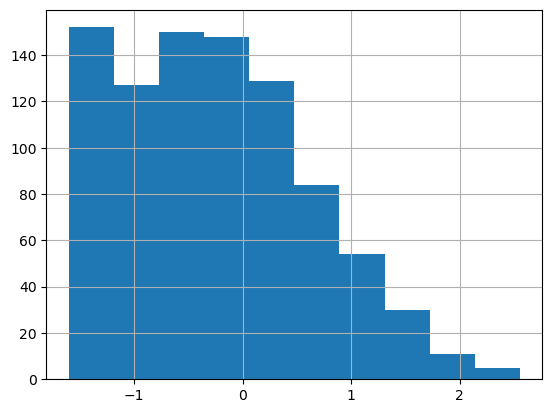

In [12]:
# ---------------------------------------------------------------------------
# Remove subjects at the minimum p_factor value and plot distributions
# ---------------------------------------------------------------------------

# Plot histogram of p_factor for all training subjects
#train_data["p_factor"].hist(bins=100)

# Print minimum value and its count
print("Minimum p_factor:", train_data["p_factor"].min())
print("Number of subjects with min value:",
      train_data["p_factor"].value_counts()[train_data["p_factor"].min()])

# Remove subjects with minimum p_factor (to avoid bias in modeling)
min_val_idx = train_data["p_factor"] == train_data["p_factor"].min()
removed_train_data = train_data[min_val_idx].copy()
clean_train_data   = train_data[~min_val_idx]

# Plot histogram after cleaning
clean_train_data["p_factor"].hist()

In [28]:
import numpy as np
import pandas as pd

from sklearn.model_selection import RepeatedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# 1. Prepare data
train_data = data[data['p_factor'].notna()].copy()

# 1a. Remove subjects with minimum p_factor
min_val = train_data['p_factor'].min()
min_idx = train_data['p_factor'] == min_val
removed = train_data[min_idx].copy()
clean   = train_data[~min_idx].copy()

# 2. Define X and y
X = clean.drop(columns=['p_factor'])
y = clean['p_factor']

# 3. Drop non-numeric columns
numeric_cols      = X.select_dtypes(include=[np.number]).columns.tolist()
non_numeric_cols  = [c for c in X.columns if c not in numeric_cols]
if non_numeric_cols:
    print('Dropping non-numeric columns:', non_numeric_cols)
X = X[numeric_cols]

# 4. Drop columns with >50% missing
missing_frac = X.isna().mean()
to_drop      = missing_frac[missing_frac > 0.5].index.tolist()
if to_drop:
    print('Dropping columns with >50% missing:', to_drop)
X = X.drop(columns=to_drop)

# 5. Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

# 6. Cross-validation strategy (for hyperparameter tuning if needed)
cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)

# 7. Define regression models
models = {
    'SVR': SVR(kernel='rbf'),
    'RandomForest': RandomForestRegressor(random_state=42),
    'LinearRegression': LinearRegression()
}

# 8. Train, predict, evaluate
results = []
for name, reg in models.items():
    pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),  # fill NaNs
        ('scaler',   StandardScaler()),               # standardize
        ('pca',      PCA(n_components=0.95)),         # keep 95% variance
        ('reg',      reg)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    # compute regression metrics
    r2   = r2_score(y_test, y_pred)
    mse  = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_test, y_pred)

    results.append({
        'model': name,
        'r2':    round(r2,   3),
        'rmse': round(rmse, 3),
        'mae':  round(mae,  3)
    })

# 9. Summarize results
results_df = pd.DataFrame(results)
print(results_df)

Dropping columns with >50% missing: ['lh_aparc_DKTatlas_frontalpole_ThickAvg', 'rh_aparc_DKTatlas_temporalpole_ThickAvg']
              model     r2   rmse    mae
0               SVR  0.020  0.788  0.634
1      RandomForest  0.028  0.785  0.650
2  LinearRegression -0.068  0.822  0.680
